## Multiscale latents 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
# import tasks.generative_1d
from tasks.hierarchical_gaussians_task import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.1
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]


# Z1 Z2!

In [3]:
# Initiate and maybe Train RNN 
train_model = False
# horizon_long_short = 'short'
horizon_long_short = 'long'
scale = 10
experiment = 9
config = Config(context_units = 4) # increase thalamus units
config.no_of_latents = 2
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':70}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=experiment)
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False
if train_model:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )

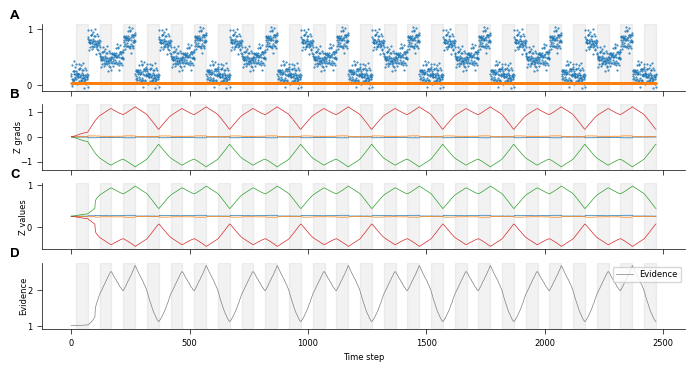

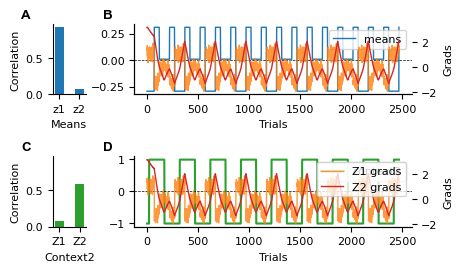

In [7]:
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = False
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = True

testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
prespecified_thalamus_untrained = np.stack(testing_memory_buffer.timestep_data['thalamus'])
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 0)
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 1)
# plot_task_and_hierarchies_illustration(testing_memory_buffer, testing_env, testing_losses, config,  )
# from plot_functions import plot_dual_modulations
plot_dual_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
# (testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 0)
# plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim = 1)

Process the thalamus, or thalamus grads to use as a latent input

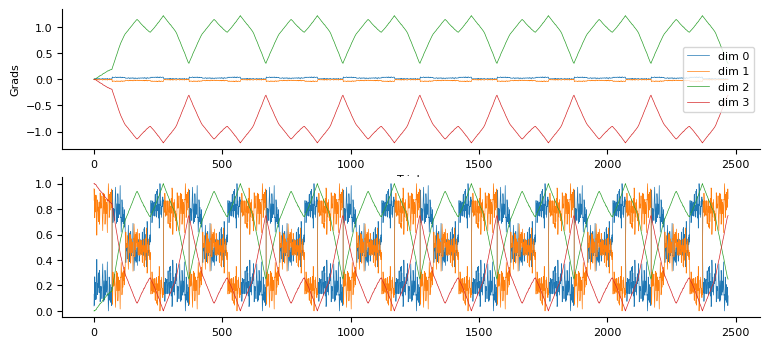

In [8]:
# plot prespecified_thalamus 
prespecified_thalamus = -np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
# print('shape of prespecified_thalamus: ', prespecified_thalamus.shape)
prespecified_thalamus[0] = 0 # first value is padded with a nan
# prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
fig, axes = plt.subplots(2,1, figsize=(9,4))
ax = axes[0]
for dim in range(prespecified_thalamus.shape[-1]):
        ax.plot(prespecified_thalamus.squeeze()[:,dim], label=f'dim {dim}', linewidth=0.5)
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()
prespecified_thalamus = prespecified_thalamus / ((np.std(prespecified_thalamus, axis=0, keepdims=True))) 
prespecified_thalamus = (prespecified_thalamus - np.min(prespecified_thalamus, axis=0, keepdims=True))/ np.ptp(prespecified_thalamus, axis=0, keepdims=True)

ax = axes[1]
ax.plot(prespecified_thalamus.squeeze()[:,], linewidth=0.5)

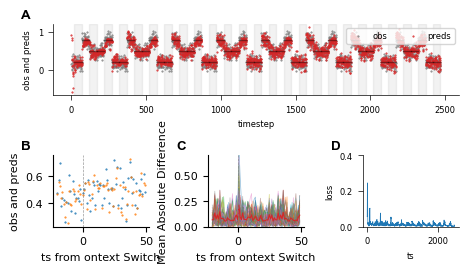

In [11]:
# Train the model
use_prespecified_thalamus = True
config.thalamus_activation_function = 'none' # important, otherwise will collapse information in the prespecified thalamus by softmax down some weird dim
# config.thalamus_activation_function = 'softmax'
_use_oracle = False
input_distort = False
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus if use_prespecified_thalamus else None, input_distort=input_distort)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

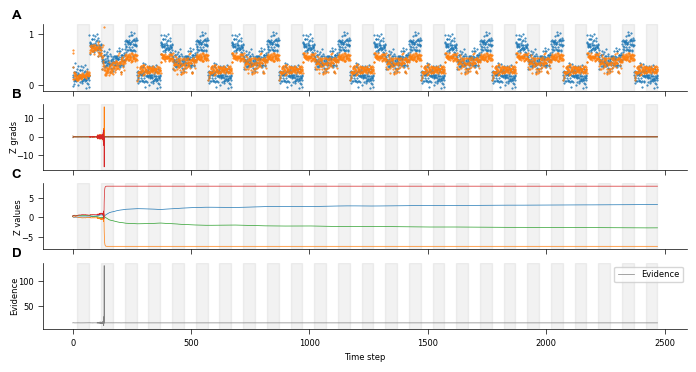

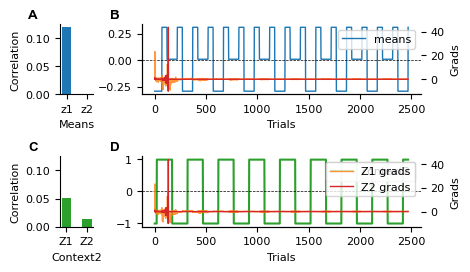

In [17]:
# test performance of thalamus enabled
testing_env = Generative_environment(config, experiment=experiment)
if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = True
config.backprop_only_last_timestep = False
config.accummulate_thalamus_temporally = True

testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
plot_dual_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)

* Check ILI carefully
* Run seeds over learning a model with ILI reps

* Check the model with single z for consistency.

* Work on exp 8 again.
* Design another exp 8

In [7]:
# # plot prespecified_thalamus 
# prespecified_thalamus = -np.stack(testing_memory_buffer.timestep_data['thalamus'])
# # print('shape of prespecified_thalamus: ', prespecified_thalamus.shape)
# prespecified_thalamus[0] = prespecified_thalamus[1] # first value is padded with a nan
# # prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
# fig, ax = plt.subplots(1,1, figsize=(9,3))
# for dim in range(prespecified_thalamus.shape[-1]):
#         ax.plot(prespecified_thalamus.squeeze()[:,dim], label=f'dim {dim}')
# ax.set_ylabel('Grads')
# ax.set_xlabel('Trials')
# ax.legend()
# temp = .01

# def thalamus_activation_function_softmax(x):
#         if config.no_of_latents == 1:
#                 sm = torch.softmax(x/config.activation_fxn_temp, dim = -1, ) # note: 0, 1 becomes 0.2689, 0.7311
#         elif config.no_of_latents > 1:
#                 latent_size = int(config.thalamus_size / config.no_of_latents)
#                 # resize x to be [seq, batch, latent_size, no_of_latents]
#                 # then softmax along the latent_size dimension
#                 # then reshape back to [seq, batch, thalamus_size]
#                 x = x.reshape(x.shape[0], x.shape[1], latent_size, config.no_of_latents)
#                 sm = torch.softmax(x, dim = 2)
#                 sm = sm.reshape(x.shape[0],  x.shape[1],config.thalamus_size)
#         return sm
# # prespecified_thalamus= model.thalamus_activation_function_softmax(torch.from_numpy(prespecified_thalamus/temp)).numpy()
# prespecified_thalamus= thalamus_activation_function_softmax(torch.from_numpy(prespecified_thalamus/temp)).reshape(-1, 1,1, config.thalamus_size).numpy()
# # normalize along the last dimension
# # prespecified_thalamus = prespecified_thalamus - np.mean(prespecified_thalamus, axis=0,keepdims=True)
# # prespecified_thalamus = prespecified_thalamus / ((np.std(prespecified_thalamus, axis=0, keepdims=True))) 
# # prespecified_thalamus = (prespecified_thalamus - np.min(prespecified_thalamus, axis=0, keepdims=True))/ np.ptp(prespecified_thalamus, axis=0, keepdims=True)
# # prespecified_thalamus = (prespecified_thalamus - np.min(prespecified_thalamus, axis=0,))/ np.ptp(prespecified_thalamus, axis=0,)

# fig, ax = plt.subplots(1,1, figsize=(9,3))
# ax.plot(prespecified_thalamus.squeeze()[:,])

In [8]:
# only grads work right now. Thalamus acvtibvations does not produce benfiits

This cell provides ground truth hierarchical latent. If run, it will be used in lieu of inferred one.

In [9]:
if False:
    # calculate means and context2 and place them in prespecified_thalamus as an experiment
    obs = testing_memory_buffer.timestep_data['obs']
    obs = np.stack(obs)
    env_key = testing_memory_buffer.timestep_data['context_names']
    means = []
    for env_key in testing_memory_buffer.timestep_data['context_names']:
        mean = testing_env.envs[env_key]['kwargs']['mean']
        means.append(mean)
    means = np.array(means)

    max_trials = config.training_phases[0]['config']['max_trials_per_block']

    context2 = np.zeros(len(obs))
    # context2 is 1 for indices from 0 to 3*max_trials trials and the -1 from 3*max_trials trials to 6*max_trials trials and so on
    for i in range(len(context2)):
        if i//(3*max_trials) % 2 == 0:
            context2[i] = .8
        else:
            context2[i] = .2
    # the very first block is a special case, choosen always to be 20 and does not belong to any of the two sequences
    # append 20 -1s to the beginning of the context2 and then remove the last 20 elements
    context2 = np.concatenate([np.ones(20)*.2, context2])
    context2 = context2[:-20]
    # add a dimension to context2 and means
    context2 = np.expand_dims(context2, axis=-1)
    means = np.expand_dims(means, axis=-1)

    prespecified_thalamus = np.concatenate([means, context2], axis=1)
    print('shape of prespecified_thalamus: ', prespecified_thalamus.shape)
    # repeat prespecified_thalamus along the last dim
    prespecified_thalamus = np.repeat(prespecified_thalamus, 2, axis=-1)
    # add a dimension to prespecified_thalamus on dim 1
    prespecified_thalamus = np.expand_dims(prespecified_thalamus, axis=1)
    prespecified_thalamus = np.expand_dims(prespecified_thalamus, axis=1)
    print('shape of prespecified_thalamus: ', prespecified_thalamus.shape)
    fig, ax = plt.subplots(1,1, figsize=(9,3))
    ax.plot(prespecified_thalamus.squeeze()[:,])

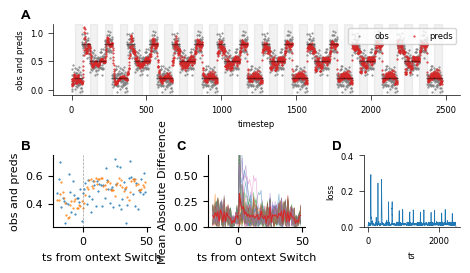

In [12]:
### NEW MODEL
use_prespecified_thalamus = True
horizon = 5
config.thalamus_activation_function = 'none' # important, otherwise will collapse information in the prespecified thalamus by softmax down some weird dim
_use_oracle = False
input_distort = False
model = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus if use_prespecified_thalamus else None, input_distort=input_distort)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)
_use_oracle = False


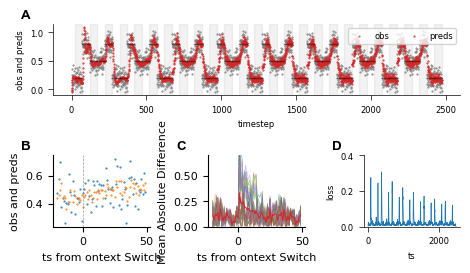

In [13]:
### NEW MODEL
use_prespecified_thalamus = False
model = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus if use_prespecified_thalamus else None, input_distort=input_distort)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

In [12]:
def get_switch_triggered_mses(logger, env):
    ''' Takes only the last ts_before timesteps before a switch to decrease the effets of adapting to the switch'''
    obs = np.stack(logger.timestep_data['obs']).squeeze()
    preds = np.stack(logger.timestep_data['predictions']).squeeze()
    switches_ts = env.env_logger['switches_ts']
    switches_ts = np.array(switches_ts)
    ts_before, ts_after = 20, 0
    mses_by_switch = []
    for i, switch in enumerate(switches_ts[1:]): # ignore the first and last switch
        if len (obs[switch-ts_before:switch+ts_after]) == ts_before+ts_after: # ensure enough data.
        # mses.append(np.abs((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])))
            mean_squared_error = np.mean((obs[switch-ts_before:switch+ts_after] - preds[switch-ts_before:switch+ts_after])**2)
            mses_by_switch.append(mean_squared_error)
    mses_by_switch = np.array(mses_by_switch)
    return mses_by_switch


In [13]:
horizon = 5
no_of_seeds = 5
loss_across_seeds_with_abstractions = []
switch_triggered_across_seeds_with_abstractions = []
for seed in [2]:#no_of_seeds):
    config.seed = seed

    use_prespecified_thalamus = True
    config.thalamus_activation_function = 'none' # important, otherwise will collapse information in the prespecified thalamus by softmax down some weird dim
    _use_oracle = False
    input_distort = False
    model = LSTM_model(config,hidden_size=100)
    env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
    logger = Logger(config) # clear the logger
    memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus if use_prespecified_thalamus else None, input_distort=input_distort)
    loss_across_seeds_with_abstractions.append(losses)
    switch_triggered_across_seeds_with_abstractions.append(get_switch_triggered_mses(memory_buffer, env))
min_length = min([len(loss) for loss in loss_across_seeds_with_abstractions])
loss_across_seeds_with_abstractions = [loss[:min_length] for loss in loss_across_seeds_with_abstractions]
loss_across_seeds_with_abstractions = np.array(loss_across_seeds_with_abstractions)


In [14]:

loss_across_seeds_vanilla = []
switch_triggered_across_seeds_vanilla = []
for seed in range(no_of_seeds):
    config.seed = seed
    use_prespecified_thalamus = False
    model = LSTM_model(config,hidden_size=100)
    env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
    logger = Logger(config) # clear the logger
    memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
            prespecified_thalamus=prespecified_thalamus if use_prespecified_thalamus else None, input_distort=input_distort)

    loss_across_seeds_vanilla.append(losses)
    switch_triggered_across_seeds_vanilla.append(get_switch_triggered_mses(memory_buffer, env))
    
min_length = min([len(loss) for loss in loss_across_seeds_vanilla])
loss_across_seeds_vanilla = [loss[:min_length] for loss in loss_across_seeds_vanilla]
loss_across_seeds_vanilla = np.array(loss_across_seeds_vanilla)

loss_mean_with_abstractions = np.mean(loss_across_seeds_with_abstractions, axis=0)
loss_mean_vanilla = np.mean(loss_across_seeds_vanilla, axis=0)



Text(0, 0.5, 'MSE')

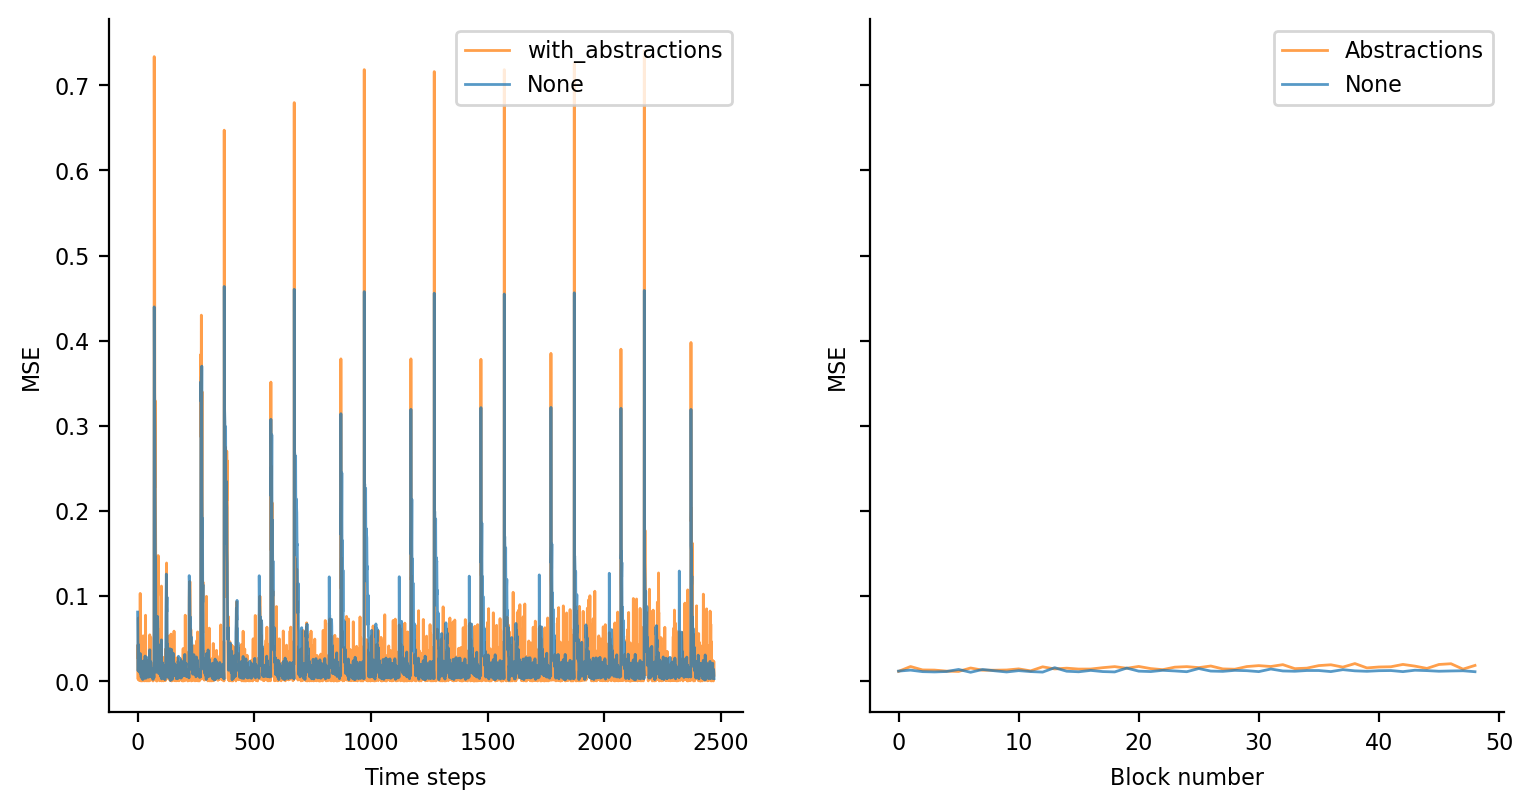

In [15]:

# convolve the loss with a window of 10
with_abstractions_color  = 'tab:blue'
no_abstractions_color = 'tab:orange'
window = 1
loss_mean_with_abstractions_filtered = np.convolve(loss_mean_with_abstractions, np.ones(window), 'valid') / window
loss_mean_vanilla_filtered = np.convolve(loss_mean_vanilla, np.ones(window), 'valid') / window

fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True, dpi=200)
# plot the loss
ax = axes[0]
ax.plot(loss_mean_with_abstractions_filtered, label='with_abstractions', linewidth=1, color = no_abstractions_color, alpha=0.75)
ax.plot(loss_mean_vanilla_filtered, label='None', linewidth=1, color = with_abstractions_color  , alpha=0.75)
ax.legend()
# ax.set_title('Loss across seeds')
ax.set_xlabel('Time steps')
ax.set_ylabel('MSE')
ax.label_outer()

ax = axes[1]
ax.label_outer()
# convolve switch triggered loss with a window of 10
window = 1
switch_triggered_across_seeds_with_abstractions = np.array(switch_triggered_across_seeds_with_abstractions)
switch_triggered_across_seeds_with_abstractions_filtered = np.convolve(np.mean(switch_triggered_across_seeds_with_abstractions, axis=0), np.ones(window), 'valid') / window
switch_triggered_across_seeds_vanilla = np.array(switch_triggered_across_seeds_vanilla)
switch_triggered_across_seeds_vanilla_filtered = np.convolve(np.mean(switch_triggered_across_seeds_vanilla, axis=0), np.ones(window), 'valid') / window

ax.plot(switch_triggered_across_seeds_with_abstractions_filtered, label='Abstractions', linewidth=1, color = no_abstractions_color, alpha=0.75)
ax.plot(switch_triggered_across_seeds_vanilla_filtered, label='None', linewidth=1, color = with_abstractions_color  , alpha=0.75)
ax.legend()
# ax.set_title('Switch triggered loss across seeds')
ax.set_xlabel('Block number')
ax.set_ylabel('MSE')
# plt.savefig('./exports/cortex_only_learning_losses.pdf', bbox_inches='tight')

# Iterate Learning and Inference ILI

In [16]:
# Initiate RNN and config 
loss_means = []
corr_Thalamus_context2s = []
corr_Thalamus_meanss = []
prespecified_thalamus_values = []

plot_plots = True
save_plots = False
use_prespecified_thalamus = True
no_of_blocks = 50
pretrain_model = False
# horizon_long_short = 'short'
horizon_long_short = 'long'
input_distort=False
scale = 10
experiment = 9
config = Config(context_units=4)
config.no_of_latents = 2
config.accummulate_thalamus_temporally = True
config.default_std = default_std
context_transition_functions = {7: 'two_sequences', 8: 'fixed_random_sequences', 9: 'experiment_9'}
training_phase_1_config = {'context_transition_function':  context_transition_functions[experiment],
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':no_of_blocks}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (3)) # note this was 3 before when I was working on exp 9
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False

if pretrain_model:
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        config.training_phases[0]['config']['no_of_blocks'] = 100
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)


for iteration in (range(3)):
        # print('running iteration: ', iteration)
        logger = Logger(config)
        env = Generative_environment(config, experiment=experiment)
        # Get latent inference values
        config.training_phases[0]['config']['no_of_blocks'] = no_of_blocks
        config.seed_env = iteration # a different sequence of random means each block, but the same fixed random pattern inside the blocks
        testing_env = Generative_environment(config, experiment=experiment)
        logger = Logger(config)
        criterion = nn.MSELoss(reduction='sum')
        _use_optimized_thalamus = False
        config.accummulate_thalamus_temporally = True
        config.thalamus_activation_function = 'none' #'softmax'
        testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, 'LU', horizon, criterion,
                                                        0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
        if plot_plots: plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
        if save_plots and plot_plots: plt.savefig(f'./exports/grads_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        # plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim =0)
        # plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf, latent_dim =2)
        plot_dual_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
        plt.show()
        plt.close('all')
        if save_plots and plot_plots: plt.savefig(f'./exports/modulations_exp_{experiment}_itr_{iteration}_hor_{horizon_long_short}.pdf', bbox_inches='tight')
        use_grads = False
        if use_grads:
                prespecified_thalamus = -np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
                prespecified_thalamus[0] = 0 # first value is padded with a nan
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = (prespecified_thalamus - np.min(prespecified_thalamus, axis=0, keepdims=True))/ np.ptp(prespecified_thalamus, axis=0, keepdims=True)
                # prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                stats(prespecified_thalamus)
        else:
                prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
                # These were already softmaxed. but I want to softmax them with a lower temperature
                prespecified_thalamus_values.append(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus - np.mean(prespecified_thalamus)
                prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
                # prespecified_thalamus = F.softmax(torch.tensor(prespecified_thalamus), dim=0, ).numpy()

        corr_context2, corr_means = get_correlations(testing_memory_buffer, testing_env, config, use_grads=use_grads, latent_dim=0)
        corr_Thalamus_context2s.append(corr_context2)
        corr_Thalamus_meanss.append(corr_means)
        # now train again with the thalamus values prespecified
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        if use_prespecified_thalamus:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
        else:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
                prespecified_thalamus=None, input_distort=input_distort)
        loss_means.append(np.mean(losses))
        if plot_plots: plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

### NEW MODEL
config.thalamus_activation_function = 'none' # important, otherwise will collapse information in the prespecified thalamus by softmax down some weird dim
model = LSTM_model(config,hidden_size=100)
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
if use_prespecified_thalamus:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
else:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger,
        prespecified_thalamus=None, input_distort=input_distort)
loss_means.append(np.mean(losses))
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

fig, axes = plt.subplots(1,2, figsize=(8,2))
ax = axes[0]
ax.plot(loss_means)
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration')
ax = axes[1]
ax.plot(corr_Thalamus_context2s, label='context2')
ax.plot(corr_Thalamus_meanss, label='means')
ax.set_ylabel('Correlation')
ax.set_xlabel('Iteration')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(9,3))
# plot each vector of thalamus values with viridis color gradations
for i in range(len(prespecified_thalamus_values)):
        ax.plot(prespecified_thalamus_values[i].squeeze()[:,0], color=plt.cm.viridis(i/len(prespecified_thalamus_values)), label=f'iter {i}')
ax.set_ylabel('Grads')
ax.set_xlabel('Trials')
ax.legend()


KeyboardInterrupt: 